## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Лапутин Фёдор Александрович

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 26 февраля.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 137961199.78it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 25735222.82it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43045413.73it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4651008.00it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

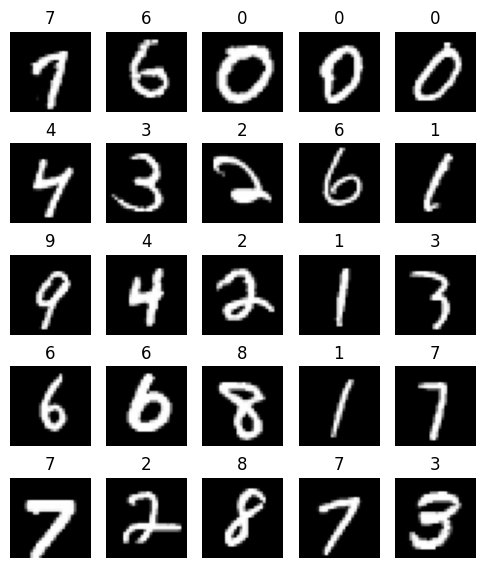

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Инициализация нормальным распределением

In [26]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [27]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0049304962158203
forward 16.141393661499023
backward 0.032317861914634705
backward 0.1834103763103485


Инициализация He

In [28]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1, 0.0, 2 / 784)
init_layer(layer_2, 0.0, 2 / 500)

network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0049304962158203
forward 0.04345318302512169
backward 0.032317861914634705
backward 0.0007182679255492985


#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

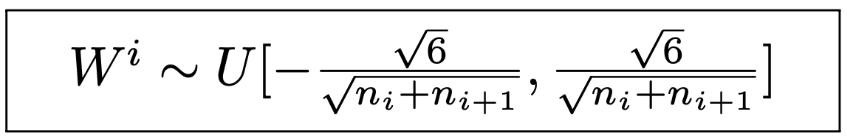

In [29]:
def init_layer(layer, from_interval=0, to_interval=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(from_interval, to_interval)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)


In [30]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0049304962158203
forward 0.9927082061767578
backward 0.032317861914634705
backward 0.005767828784883022


Выводы:
- При инициализации весов нормальным распределением с параметрами 0 и 1 дисперсия весов на разных слоях отличается, что не лучшим образом скажется на обучении сети.
- При инициализации весов с помощью He дисперсии более менее одинаковые.
- При инициализации весов с помощью Xavier дисперсии также более менее одинаковые.
- He используется для функции активации ReLU, а Xavier - для Tanh.  

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

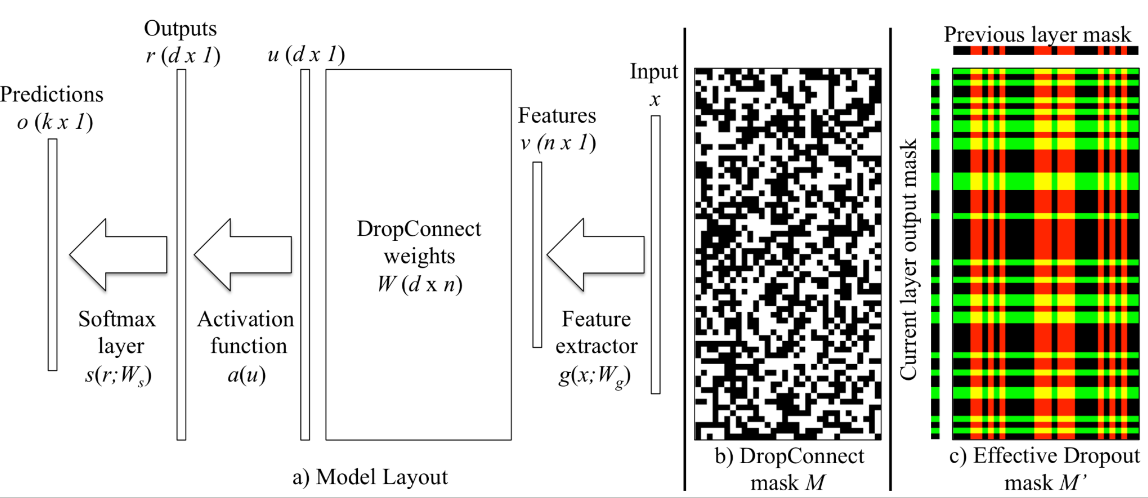

In [64]:
class Dropout(nn.Module):
    def __init__(self, p=0.5, device="cpu"):
        super(Dropout, self).__init__()
        self.p = p
        self.device = device

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        mask = mask.to(device)

        return x * mask

In [65]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.empty_like(self.linear.weight).bernoulli_(1 - self.p)
            mask = mask / (1 - self.p)
        else:
            mask = torch.ones_like(self.linear.weight)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [7]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


Dropout

In [67]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

dropout_losses = []
for epoch in range(10):
    network.train()
    network = network.to(device)
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        X = X.to(device)
        y = y.to(device)

        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data.to(device)
        y = labels_test.data.to(device)
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))

    dropout_losses.append(np.mean(losses))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.294897
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.120571
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.709480
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.531386
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.516093
Test Epoch: 0	Loss: 0.371727
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.464466
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.216313
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.380750
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.248990
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.312708
Test Epoch: 1	Loss: 0.225598
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.213138
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.234506
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.165329
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.311657
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.205860
Test Epoch: 2	Loss: 0.175529
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.146885
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.156372
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.090169
Train Epoch: 3 [38400/60000 (64%)

DropConnect

In [68]:
layers = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

dropconnect_losses = []
for epoch in range(10):
    network.train()
    network = network.to(device)
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        X = X.to(device)
        y = y.to(device)

        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data.to(device)
        y = labels_test.data.to(device)
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))

    dropconnect_losses.append(np.mean(losses))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.305713
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.014969
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.582962
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.555362
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.424830
Test Epoch: 0	Loss: 0.284285
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.413753
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.398178
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.277248
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.230087
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.289769
Test Epoch: 1	Loss: 0.163646
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.228729
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.289729
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.112082
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.274409
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.169775
Test Epoch: 2	Loss: 0.135620
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.228668
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.151950
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.178106
Train Epoch: 3 [38400/60000 (64%)

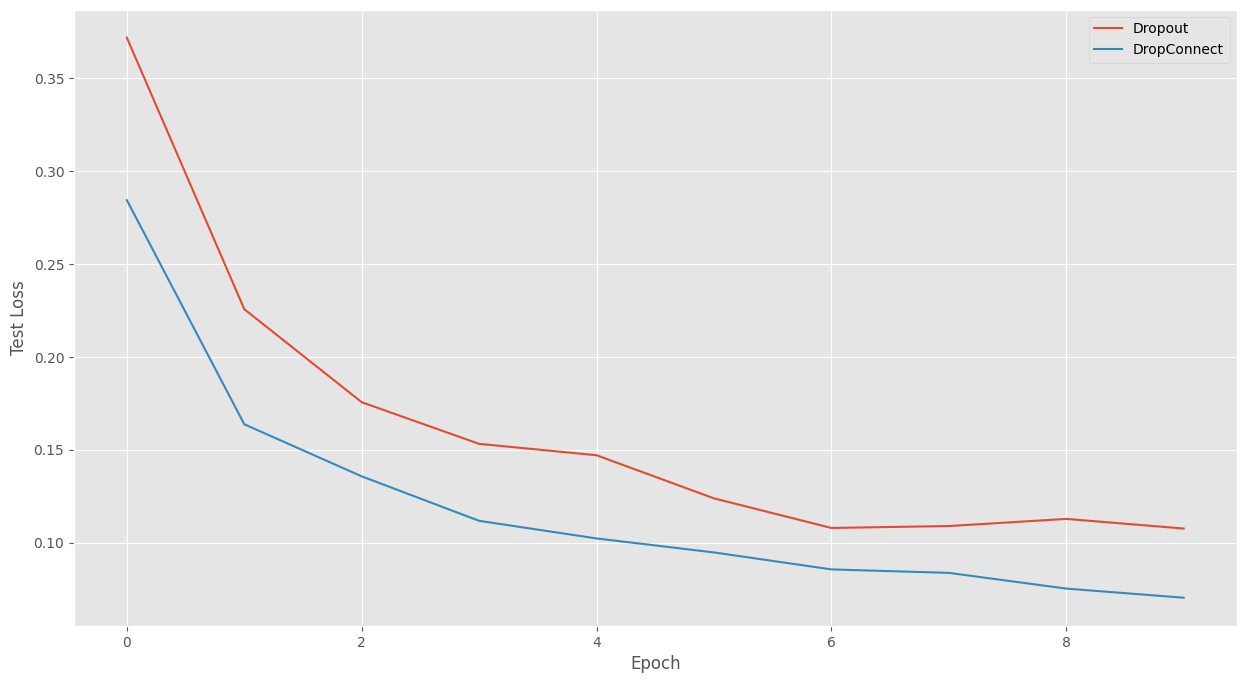

In [75]:
plt.figure(figsize=(15, 8))
plt.style.use('ggplot')

epochs = list(range(10))
plt.plot(epochs, dropout_losses, label="Dropout")
plt.plot(epochs, dropconnect_losses, label="DropConnect")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.show()

Выводы:
- Оба метода приводят к сходимости.
- При использовании DropConnect лосс на тесте заметно меньше, чем во время использования Dropout.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

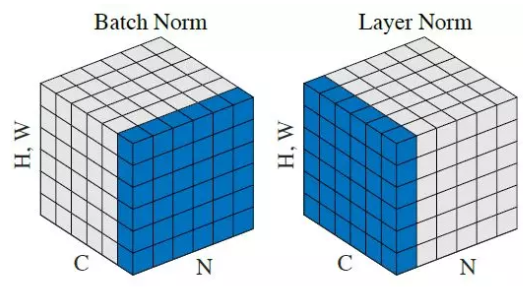

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [10]:
# полезные функции: .std(dim), .mean(dim)
class LayerNormalization(nn.Module):
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        output = (x - mean) / (std + 1e-6)
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [8]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

batchnorm_losses = []
for epoch in range(10):
    network.train()
    network = network.to(device)
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        X = X.to(device)
        y = y.to(device)

        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data.to(device)
        y = labels_test.data.to(device)
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))

    batchnorm_losses.append(np.mean(losses))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.381140
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.325295
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.186479
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.085937
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.048794
Test Epoch: 0	Loss: 0.094163
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.074039
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.101997
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.055583
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.119125
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.071409
Test Epoch: 1	Loss: 0.067173
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.050998
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.053764
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.044835
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.121884
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.067113
Test Epoch: 2	Loss: 0.060198
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.025512
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.019141
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.034826
Train Epoch: 3 [38400/60000 (64%)

In [11]:
layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(128, 128),
    nn.ReLU(),
    LayerNormalization(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

layernorm_losses = []
for epoch in range(10):
    network.train()
    network = network.to(device)
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        X = X.to(device)
        y = y.to(device)

        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data.to(device)
        y = labels_test.data.to(device)
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))

    layernorm_losses.append(np.mean(losses))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.933520
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.189257
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.173294
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.230185
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.108274
Test Epoch: 0	Loss: 0.122479
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.062873
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.102246
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.080108
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.067463
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.050942
Test Epoch: 1	Loss: 0.091196
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.118435
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.194797
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.078028
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.076803
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.054565
Test Epoch: 2	Loss: 0.079236
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.101156
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.032317
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.090022
Train Epoch: 3 [38400/60000 (64%)

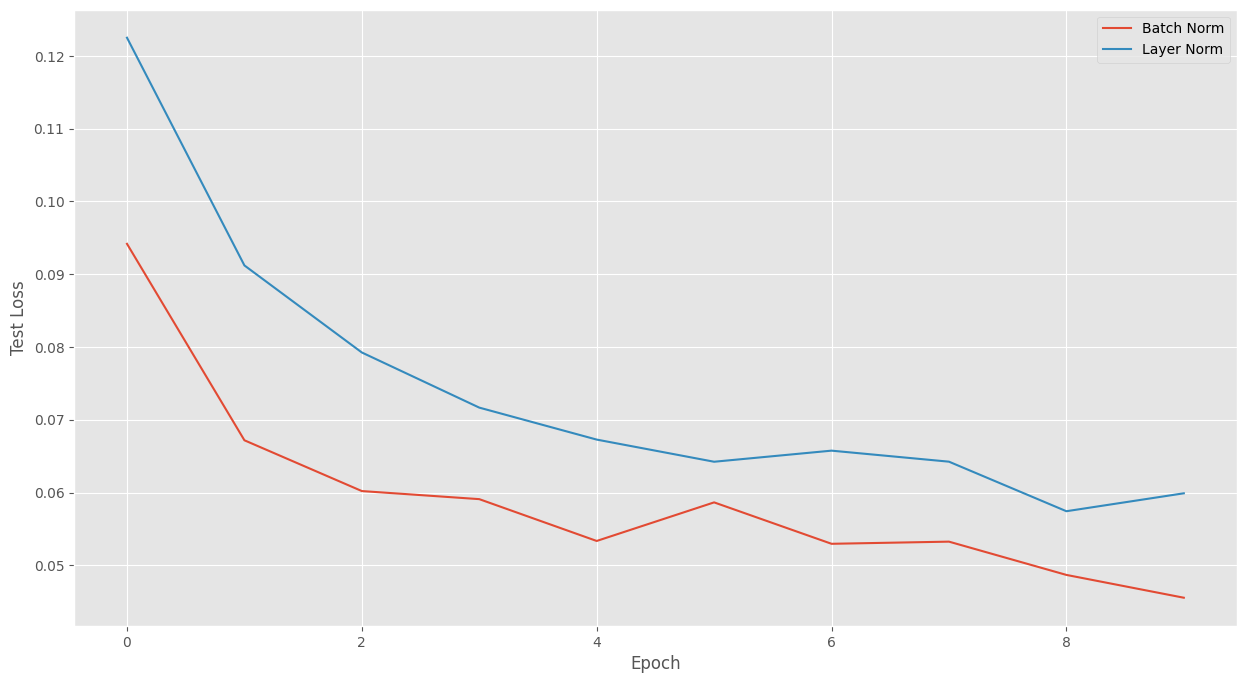

In [13]:
plt.figure(figsize=(15, 8))
plt.style.use('ggplot')

epochs = list(range(10))
plt.plot(epochs, batchnorm_losses, label="Batch Norm")
plt.plot(epochs, layernorm_losses, label="Layer Norm")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.show()

Выводы:
- На данном наборе данных Batch Norm дал более быструю сходимость и меньшее значения лосса на тестовой выборке по сравнению с Layer Norm